# TUGAS KELOMPOK BIG DATA
## TEKNIK ANALISIS BIG DATA
Nama Anggota Kelompok 3 :
- Satria Dali Romadhon (09021182227001)
- Zweta Anggun Syafara (09021182227010)
- Bagas Ramandari (09021282227101)
- Muhammad Aditya Bayhaqie (09021282227122)


## Library Installation

In [ ]:
!pip install -q pyspark findspark gdown seaborn matplotlib
!pip install lazypredict
!pip install optuna
!pip install catboost
!pip install lightgbm
!pip install xgboost

In [ ]:
import findspark
findspark.init()

from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *
import pandas as pd
import numpy as np
import missingno
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler , PowerTransformer , RobustScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split , cross_val_score , KFold

from lazypredict.Supervised import LazyRegressor
import optuna
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.ensemble import  ExtraTreesRegressor , StackingRegressor , GradientBoostingRegressor

import lightgbm
import xgboost as xgb
import catboost

from sklearn.compose import TransformedTargetRegressor
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import PowerTransformer
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.ensemble import (
    ExtraTreesRegressor, StackingRegressor, GradientBoostingRegressor
)

from IPython.display import display

## SPARK Set-up

Baris ini digunakan untuk membuat SparkSession yang mengatur lingkungan kerja Spark secara lokal dengan alokasi memori tertentu sehingga aplikasi dapat memproses data besar menggunakan PySpark.


In [ ]:
# Mulai SparkSession
spark = SparkSession.builder \
    .master("local[*]") \
    .appName("BeerReviewAnalysis") \
    .config("spark.executor.memory", "4g") \
    .config("spark.driver.memory", "4g") \
    .getOrCreate()

print("Spark ready!")

Spark ready!


Masukkan dataset beer_reviews.csv dari gdrive

## Load Dataset

Lakukan load dataset dengan menampilkan jumlah baris keseluruhan dataset

In [ ]:
!pip install -q kaggle

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! mkdir ~/.kaggle

In [ ]:
!cp /content/drive/MyDrive/CollabData/kaggle_API/kaggle.json ~/.kaggle/kaggle.json

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download thedevastator/1-5-million-beer-reviews-from-beer-advocate

Dataset URL: https://www.kaggle.com/datasets/thedevastator/1-5-million-beer-reviews-from-beer-advocate
License(s): CC-BY-NC-SA-4.0
  0% 0.00/32.5M [00:00<?, ?B/s]
100% 32.5M/32.5M [00:00<00:00, 1.04GB/s]


In [ ]:
!unzip 1-5-million-beer-reviews-from-beer-advocate

Archive:  1-5-million-beer-reviews-from-beer-advocate.zip
  inflating: beer_reviews.csv        


In [ ]:
csv_path = "/content/beer_reviews.csv"

In [ ]:
# Load dataset ke Spark
df = spark.read.option("header", True).csv(csv_path, inferSchema=True)

print("Jumlah baris:", df.count())
df.printSchema()
df.show(5)

Jumlah baris: 1586614
root
 |-- index: integer (nullable = true)
 |-- brewery_id: integer (nullable = true)
 |-- brewery_name: string (nullable = true)
 |-- review_time: integer (nullable = true)
 |-- review_overall: double (nullable = true)
 |-- review_aroma: double (nullable = true)
 |-- review_appearance: double (nullable = true)
 |-- review_profilename: string (nullable = true)
 |-- beer_style: string (nullable = true)
 |-- review_palate: double (nullable = true)
 |-- review_taste: double (nullable = true)
 |-- beer_name: string (nullable = true)
 |-- beer_abv: double (nullable = true)
 |-- beer_beerid: integer (nullable = true)

+-----+----------+--------------------+-----------+--------------+------------+-----------------+------------------+--------------------+-------------+------------+--------------------+--------+-----------+
|index|brewery_id|        brewery_name|review_time|review_overall|review_aroma|review_appearance|review_profilename|          beer_style|review_palate|

## Pre-Processing Dataset

In [ ]:
# Preprocessing (minimal 2 tahap)
# 1) Drop baris dengan missing values
# 2) Konversi kolom numeric
# -------------------------------
df_clean = df.dropna()

# Konversi kolom rating ke numeric
df2 = df_clean.withColumn("review_overall", col("review_overall").cast("double"))

# Filtering contoh: hanya rating >= 4
df2 = df2.filter(col("review_overall") >= 4.0)

print("Setelah cleaning & filter — jumlah baris:", df2.count())
df2.show(5)

Setelah cleaning & filter — jumlah baris: 963090
+-----+----------+--------------------+-----------+--------------+------------+-----------------+------------------+--------------------+-------------+------------+-------------------+--------+-----------+
|index|brewery_id|        brewery_name|review_time|review_overall|review_aroma|review_appearance|review_profilename|          beer_style|review_palate|review_taste|          beer_name|beer_abv|beer_beerid|
+-----+----------+--------------------+-----------+--------------+------------+-----------------+------------------+--------------------+-------------+------------+-------------------+--------+-----------+
|    4|      1075|Caldera Brewing C...| 1293735206|           4.0|         4.5|              4.0|    johnmichaelsen|American Double /...|          4.0|         4.5|      Cauldron DIPA|     7.7|      64883|
|    8|      1075|Caldera Brewing C...| 1290454503|           4.0|         3.0|              3.5|     LordAdmNelson|Herbed / Sp

## EDA

ANALISIS 1

Menghitung rata-rata dan jumlah review tiap beer, memfilter yang reviewnya ≥100, lalu mengurutkannya berdasarkan rating tertinggi untuk menemukan beer terbaik.

In [ ]:
#ANALISIS 1

# -------------------------------
# Sorting / analisis
# -------------------------------
# Top beers by average rating (dengan ≥100 review)
beer_summary = (df2.groupBy("beer_name")
                .agg(
                    avg("review_overall").alias("avg_rating"),
                    count("*").alias("n_reviews")
                )
                .filter(col("n_reviews") >= 100)
                .sort(desc("avg_rating"), desc("n_reviews"))
               )

print("--- Top beers by average rating (with >=100 reviews) ---")
beer_summary.show(10)

--- Top beers by average rating (with >=100 reviews) ---
+--------------------+------------------+---------+
|           beer_name|        avg_rating|n_reviews|
+--------------------+------------------+---------+
|Deviation - Bottl...| 4.675925925925926|      108|
|Trappist Westvlet...| 4.666394779771615|     1226|
|   Pliny The Younger| 4.662371134020619|      582|
|          Citra DIPA| 4.653225806451613|      248|
| Live Oak HefeWeizen|4.6524590163934425|      305|
|Cantillon Blåbær ...| 4.650326797385621|      153|
|     Pliny The Elder| 4.645533141210374|     2429|
|Portsmouth Kate T...| 4.641791044776119|      402|
|        Heady Topper| 4.635483870967742|      465|
|Founders CBS Impe...| 4.624398073836276|      623|
+--------------------+------------------+---------+
only showing top 10 rows


ANALISIS 2

Mencari beer dengan jumlah review terbanyak dengan mengelompokkan data berdasarkan nama beer, menghitung total review, lalu mengurutkannya dari yang paling banyak.

In [ ]:
#ANALISIS 2

# Beer dengan review terbanyak
top_reviewed = (df2.groupBy("beer_name")
                .agg(count("*").alias("n_reviews"))
                .sort(desc("n_reviews"))
               )
print("--- Beers with most reviews ---")
top_reviewed.show(10)

--- Beers with most reviews ---
+--------------------+---------+
|           beer_name|n_reviews|
+--------------------+---------+
|       90 Minute IPA|     2710|
|Old Rasputin Russ...|     2654|
|Sierra Nevada Cel...|     2542|
|     Two Hearted Ale|     2448|
|     Pliny The Elder|     2429|
|Founders Breakfas...|     2299|
|Stone IPA (India ...|     2289|
| Stone Ruination IPA|     2282|
|Sierra Nevada Pal...|     2272|
|  Bell's Hopslam Ale|     2219|
+--------------------+---------+
only showing top 10 rows


ANALISIS 3

Mencari brewery dengan rata-rata rating tertinggi dengan menghitung rata-rata dan jumlah review per brewery, memfilter yang memiliki ≥100 review, lalu mengurutkannya berdasarkan rating tertinggi.

In [ ]:
  #ANALISIS 3

# -------------------------------
# Brewery dengan rata-rata rating tertinggi
# -------------------------------
brewery_summary = (
    df2.groupBy("brewery_id")
       .agg(
           avg("review_overall").alias("avg_rating"),
           count("*").alias("n_reviews")
       )
       .filter(col("n_reviews") >= 100)
       .sort(desc("avg_rating"))
)

print("--- Top Breweries by Rating (>=100 reviews) ---")
brewery_summary.show(10)


--- Top Breweries by Rating (>=100 reviews) ---
+----------+------------------+---------+
|brewery_id|        avg_rating|n_reviews|
+----------+------------------+---------+
|       313|4.6116289391921885|     2253|
|     27039| 4.599229287090559|      519|
|       464| 4.518691588785047|      107|
|       383| 4.496969696969697|      495|
|      2150| 4.487704918032787|      122|
|       863|4.4776647286821705|    10320|
|     10902| 4.458333333333333|      192|
|       911| 4.449891067538126|      459|
|     16410| 4.440740740740741|      270|
|       252| 4.438083043716847|     5467|
+----------+------------------+---------+
only showing top 10 rows


ANALISIS 4

Menganalisis tren rating per tahun dengan mengekstrak tahun dari waktu review, menghitung rata-rata rating dan jumlah review tiap tahun, lalu menampilkannya secara berurutan berdasarkan tahun.

In [ ]:
#ANALISIS 4

# -------------------------------
# Trend rating per tahun
# -------------------------------
df_year = df2.withColumn("year", year(from_unixtime(col("review_time"))))

trend_year = (
    df_year.groupBy("year")
           .agg(avg("review_overall").alias("avg_rating"),
                count("*").alias("n_reviews"))
           .sort("year")
)

print("--- Trend Rating per Tahun ---")
trend_year.show()


--- Trend Rating per Tahun ---
+----+-----------------+---------+
|year|       avg_rating|n_reviews|
+----+-----------------+---------+
|1996|              4.0|        1|
|1998|4.196428571428571|       56|
|1999|4.145833333333333|       24|
|2000|4.283132530120482|       83|
|2001|4.391849529780564|     1276|
|2002|4.294878727019929|    12946|
|2003|4.262395489014194|    30858|
|2004|4.264799154334038|    39732|
|2005|4.275052423000711|    51981|
|2006|4.263927613585066|    75318|
|2007|4.263193398783352|    83015|
|2008|4.258962828339314|   128754|
|2009|4.262023184900557|   153807|
|2010|4.260578108926816|   175953|
|2011|4.227787225258522|   203464|
|2012|4.225094469254552|     5822|
+----+-----------------+---------+



Menampilkan distribusi rating dengan mengonversi kolom review_overall ke pandas lalu membuat histogram untuk melihat sebaran nilai rating.

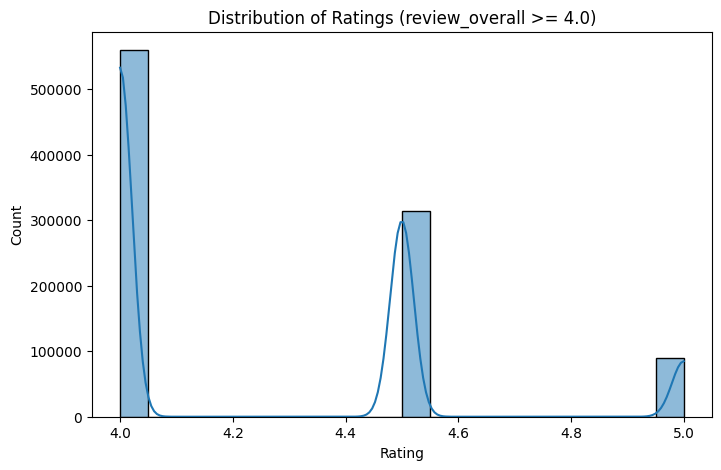

In [ ]:
# -------------------------------
# Distribusi rating (visualisasi)
# -------------------------------
import matplotlib.pyplot as plt
import seaborn as sns

pdf = df2.select("review_overall").toPandas()

plt.figure(figsize=(8,5))
sns.histplot(pdf["review_overall"], bins=20, kde=True)
plt.title("Distribution of Ratings (review_overall >= 4.0)")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.show()

Menganalisis jenis beer dengan menghitung rata-rata rating dan jumlah review tiap beer_style, memfilter style dengan ≥50 review, lalu menampilkannya berdasarkan rating tertinggi.

In [ ]:
if "beer_style" in df2.columns:
    style_summary = (df2.groupBy("beer_style")
                     .agg(
                        avg("review_overall").alias("avg_rating"),
                        count("*").alias("n_reviews")
                     )
                     .filter(col("n_reviews") >= 50)
                     .sort(desc("avg_rating"))
                    )
    print("--- Beer style summary (avg rating, #reviews) ---")
    style_summary.show(10)

--- Beer style summary (avg rating, #reviews) ---
+--------------------+-----------------+---------+
|          beer_style|       avg_rating|n_reviews|
+--------------------+-----------------+---------+
|   American Wild Ale| 4.35915071770335|    13376|
|  Lambic - Unblended|4.350888324873097|      788|
|    Quadrupel (Quad)|4.344144472820139|    13705|
|               Kvass|          4.34375|       96|
|              Gueuze|4.340642963593783|     4697|
|  Berliner Weissbier|4.332046332046332|     2072|
|American Double /...|4.322576406590808|    38053|
|    Flanders Red Ale|4.320443143812709|     4784|
|      Lambic - Fruit|4.308418104083739|     6783|
|          Hefeweizen|4.307071269487751|    17960|
+--------------------+-----------------+---------+
only showing top 10 rows


In [ ]:
# -------------------------------
# Simpan hasil ke CSV (opsional)
# -------------------------------
beer_summary.toPandas().to_csv("/content/drive/MyDrive/top_beers_by_rating.csv", index=False)
top_reviewed.toPandas().to_csv("/content/drive/MyDrive/most_reviewed_beers.csv", index=False)

print("Selesai analisis.")

Selesai analisis.


## Feature Encoding

In [ ]:
beer = pd.read_csv("/content/beer_reviews.csv")
beer = pd.get_dummies(beer, columns=["beer_style"], drop_first=True)
print("Dataset setelah feature encoding:")
display(beer.head())

Dataset setelah feature encoding:


,index,brewery_id,brewery_name,review_time,review_overall,review_aroma,review_appearance,review_profilename,review_palate,review_taste,...,beer_style_Scotch Ale / Wee Heavy,beer_style_Scottish Ale,beer_style_Scottish Gruit / Ancient Herbed Ale,beer_style_Smoked Beer,beer_style_Tripel,beer_style_Vienna Lager,beer_style_Weizenbock,beer_style_Wheatwine,beer_style_Winter Warmer,beer_style_Witbier
0,0,10325,Vecchio Birraio,1234817823,1.50,2.00,2.50,stcules,1.50,1.50,...,False,False,False,False,False,False,False,False,False,False
1,1,10325,Vecchio Birraio,1235915097,3.00,2.50,3.00,stcules,3.00,3.00,...,False,False,False,False,False,False,False,False,False,False
2,2,10325,Vecchio Birraio,1235916604,3.00,2.50,3.00,stcules,3.00,3.00,...,False,False,False,False,False,False,False,False,False,False
3,3,10325,Vecchio Birraio,1234725145,3.00,3.00,3.50,stcules,2.50,3.00,...,False,False,False,False,False,False,False,False,False,False
4,4,1075,Caldera Brewing Company,1293735206,4.00,4.50,4.00,johnmichaelsen,4.00,4.50,...,False,False,False,False,False,False,False,False,False,False


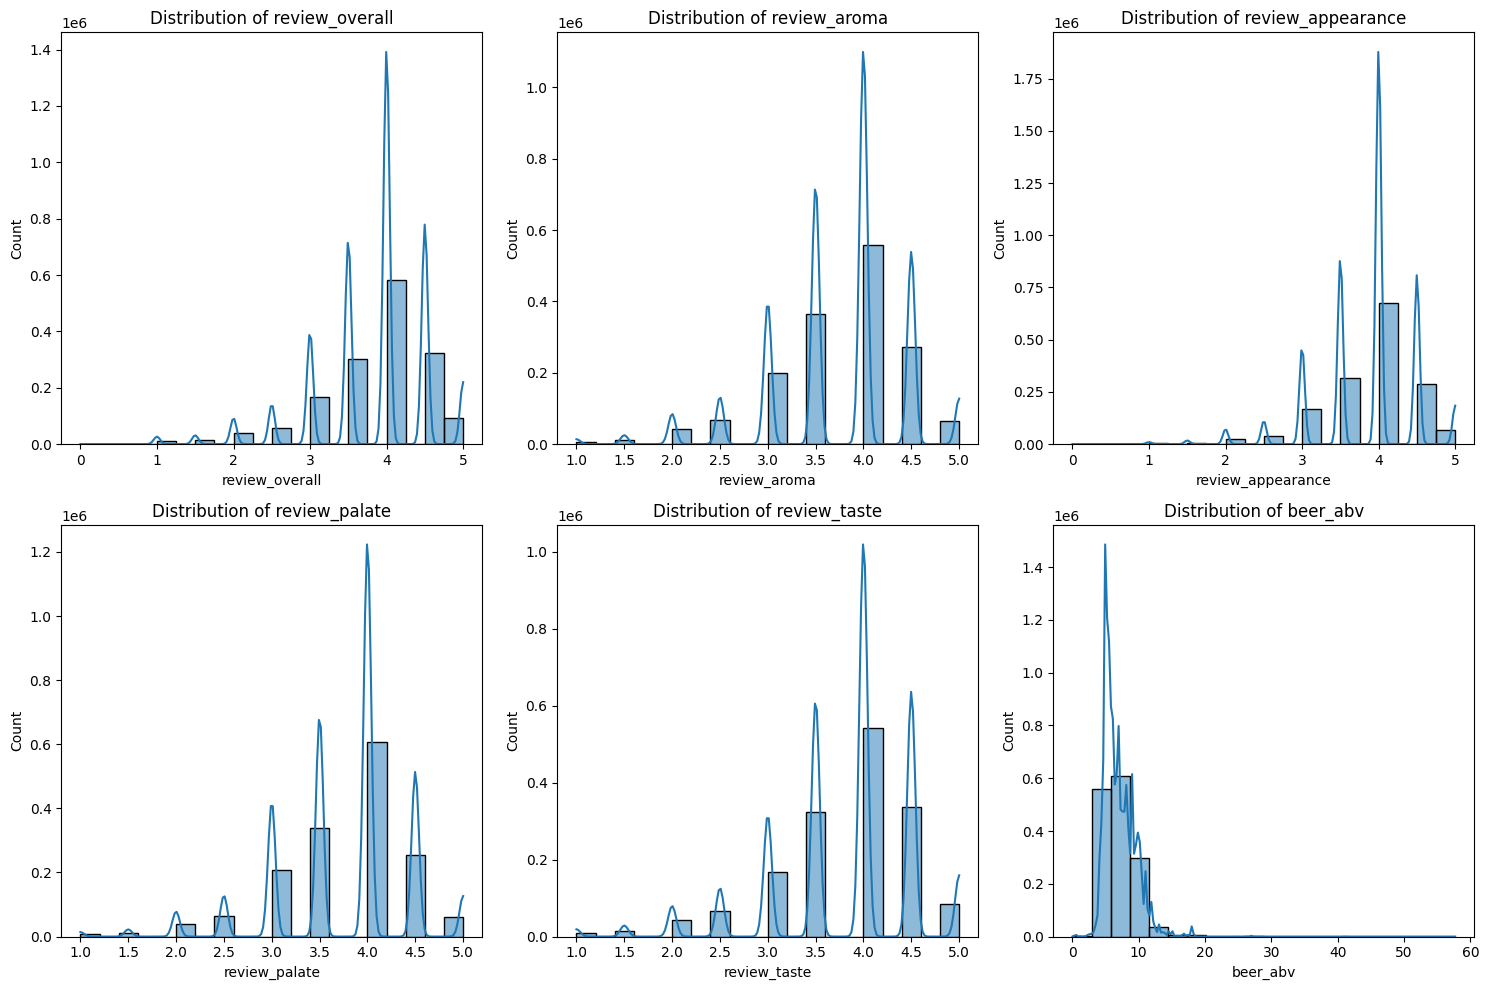

In [ ]:
numerical_features = [
    'review_overall',
    'review_aroma',
    'review_appearance',
    'review_palate',
    'review_taste',
    'beer_abv'
]

plt.figure(figsize=(15, 10))
for i, feature in enumerate(numerical_features):
    plt.subplot(2, 3, i + 1) # Arrange plots in a 2x3 grid
    sns.histplot(beer[feature].dropna(), kde=True, bins=20)
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Count')
plt.tight_layout()
plt.show()

<Axes: >

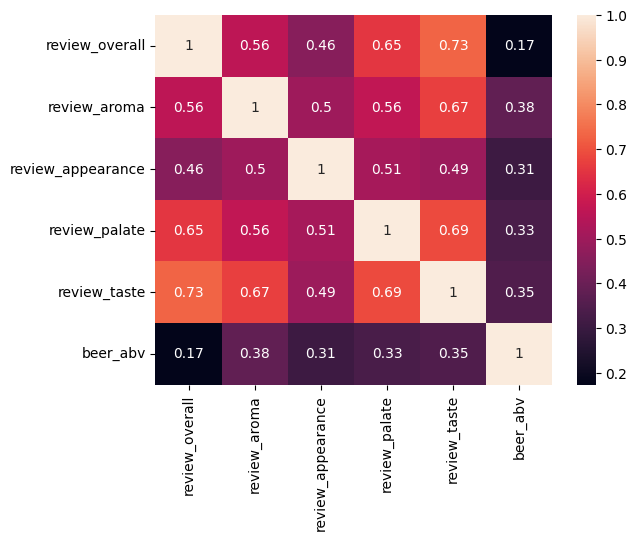

In [ ]:
multi = beer[[    'review_overall',
    'review_aroma',
    'review_appearance',
    'review_palate',
    'review_taste',
    'beer_abv'
]]

multiq = multi.corr(method='spearman')

sns.heatmap(data=multiq, annot=True, fmt='.2g')

## Modelling

### Optuna

In [ ]:
# # Data preparation (reducing the dataset, cleaning, and splitting)
# # beer_reduced = beer.sample(frac=0.8, random_state=12)

# beer_cleaned = beer.dropna(subset=['review_overall', 'review_aroma', 'review_appearance', 'review_palate', 'review_taste', 'beer_abv'])

# y = beer_cleaned['review_overall']
# X = beer_cleaned.drop(columns=['index', 'brewery_id', 'brewery_name', 'review_time', 'review_overall', 'review_profilename', 'beer_name', 'beer_beerid'])

# # Ensure all X columns are numeric
# X = X.select_dtypes(include=np.number)

# # Split data into training and testing sets
# x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12, shuffle=True)

# def LightGBM_objective(trial):
#     # SET HYPERPARAMETERS VALUE RANGE for LightGBM
#     params = {
#         'objective': 'regression',
#         'metric': 'rmse',
#         'n_estimators': trial.suggest_int('n_estimators', 100, 2000),
#         'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
#         'num_leaves': trial.suggest_int('num_leaves', 2, 256),
#         'max_depth': trial.suggest_int('max_depth', -1, 50),
#         'min_child_samples': trial.suggest_int('min_child_samples', 20, 500),
#         'subsample': trial.suggest_float('subsample', 0.6, 1.0),
#         'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
#         'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0),
#         'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 1.0),
#         'random_state': 12,
#         'n_jobs': -1,
#     }

#     # SET MODEL
#     model = lightgbm.LGBMRegressor(**params)

#     # SCORE METRICS
#     # Optuna minimizes by default, so 'neg_root_mean_squared_error' is appropriate
#     score = cross_val_score(estimator=model, X=x_train, y=y_train,
#                             scoring='neg_root_mean_squared_error', cv=3)

#     return score.mean()

# # BUILD A OPTUNA study for LightGBM
# study = optuna.create_study(direction='maximize') # Maximize negative RMSE
# study.optimize(func=LightGBM_objective, n_trials=100) # You can adjust n_trials for longer/shorter runs

# print(f'Best LightGBM CV    : {study.best_params}')
# print(f'Best LightGBM Score : {study.best_value}')

# # GET BEST HYPERPARAMETERS
# lgbm_best_params = study.best_params

## LightBGM

In [ ]:
import lightgbm as lgb
model_pre = lgb.LGBMRegressor()

In [ ]:
params = {
    "n_estimators": [50, 100, 500, 1000],
    "learning_rate": [0.01, 0.05, 0.1, 0.3],
    "lambda_l1": [0, 10, 20, 30, 50],
    "lambda_l2": [0, 10, 20, 30, 50],
    "max_depth": [3, 5, 10, 15, 20],
    "subsample": [0.6, 0.8, 1]
}

In [ ]:
from sklearn.model_selection import RandomizedSearchCV, train_test_split

In [ ]:
model = RandomizedSearchCV(model_pre, param_distributions=params, n_iter=30, n_jobs=-1, verbose=2)
x = beer.drop(["brewery_id", "review_overall", "review_profilename", "brewery_name", "beer_name"], axis=1)
y = beer["review_overall"]
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=100)

In [ ]:
model.fit(x_train, y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023985 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1186
[LightGBM] [Info] Number of data points in the train set: 1189960, number of used features: 111
[LightGBM] [Info] Start training from score 3.816253


RandomizedSearchCV(estimator=LGBMRegressor(), n_iter=30, n_jobs=-1,
                   param_distributions={'lambda_l1': [0, 10, 20, 30, 50],
                                        'lambda_l2': [0, 10, 20, 30, 50],
                                        'learning_rate': [0.01, 0.05, 0.1, 0.3],
                                        'max_depth': [3, 5, 10, 15, 20],
                                        'n_estimators': [50, 100, 500, 1000],
                                        'subsample': [0.6, 0.8, 1]},
                   verbose=2)

In [ ]:
model.best_params_

{'subsample': 1,
 'n_estimators': 1000,
 'max_depth': 15,
 'learning_rate': 0.1,
 'lambda_l2': 10,
 'lambda_l1': 20}

In [ ]:
model.best_estimator_.feature_importances_

array([4713, 6198, 1445, 1233, 1756, 1999, 4833, 4519,  145,   54,   26,
         67,   18,   55,   29,    0,   18,   13,   74,   80,   38,   71,
         53,   56,   81,   53,   64,   33,   21,   26,    9,   14,   47,
         40,    8,    1,   10,    0,   27,   12,    8,   34,   22,   53,
         39,   34,   21,   18,    5,    1,   17,    2,   20,   28,   37,
          4,   33,   15,   33,    7,   89,    5,   18,   17,   16,   34,
         20,   70,   70,    0,   21,   16,   50,   36,   35,   20,   25,
         21,   22,    0,   52,   49,   11,   93,    1,   21,   30,    7,
         43,   58,   47,   45,   36,   25,   36,    0,   73,   32,   12,
         66,   10,   33,   18,   30,   19,   31,   28,    0,   23,   64,
         52], dtype=int32)

## Evaluation

In [ ]:
model.score(x_train, y_train)

[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20


0.7040364714100849

In [ ]:
model.score(x_test, y_test)

[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20


0.698693471315598

## Comparison

In [ ]:
pred = model.predict(x)
beer["score_prediction"] = pred
beer["gap"] = abs(beer["score_prediction"] - beer["review_overall"])
beer[["beer_beerid", "review_overall", "score_prediction", "gap"]].head(30)

[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20


PySparkTypeError: [NOT_COLUMN_OR_STR] Argument `col` should be a Column or str, got Series.